<a href="https://colab.research.google.com/github/adriannag9/machine-learning/blob/main/ru_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required Russian NLP libraries
!pip install pymorphy2 pymystem3

import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, metrics, svm
from sklearn import ensemble
import pymorphy2
from pymystem3 import Mystem
from nltk.corpus import stopwords

# Download NLTK resources
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
# Path adjusted for Google Drive storage
raw_data = pd.read_csv('/content/drive/My Drive/projekt_ml/sentiment_dataset.csv')

# Prepare data lists
texts = raw_data['text'].astype(str).tolist()
labels = raw_data['label'].tolist()

# Create main DataFrame
trainDF = pd.DataFrame()
trainDF['text'] = texts
trainDF['label'] = labels

# Display initial data statistics and preview
print(trainDF.head(100))
print(trainDF.describe())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                                 text  label
0   Пальто красивое, но пришло с дырой в молнии. П...      0
1   Очень долго шел заказ,ждала к новому году,приш...      0
2   Могу сказать одно, брюки нормальные, НО они бы...      0
3   Доставка быстрая, меньше месяца. Заказывали ра...      0
4   Мне не очень  понравилось это платье. Размер  ...      0
..                                                ...    ...
95  Доставка 63 дня!!! Качество хорошее, на ОГ95, ...      0
96  мой размер одежды 40, поэтому думаю понимаете,...      0
97  Покрой халата очень странный, рукава очень дли...      0
98  заказывала две с длинным рукавом, одна пришла ...      0
99         не соответствует фото.Качество другое. :((      0

[100 rows x 2 columns]
               label
count  290458.000000
mean        1.001387
std         0.816375
min         0.000000
25%       

In [ ]:
# DATA ANALYSIS (Exploratory Data Analysis)
# 1. Word count analysis
train = trainDF.copy()
train['word_count'] = train['text'].apply(lambda x: len(str(x).split(" ")))

print("Word count preview:")
print(train[['text','word_count']].head())

Word count preview:
                                                text  word_count
0  Пальто красивое, но пришло с дырой в молнии. П...          50
1  Очень долго шел заказ,ждала к новому году,приш...          11
2  Могу сказать одно, брюки нормальные, НО они бы...          49
3  Доставка быстрая, меньше месяца. Заказывали ра...          20
4  Мне не очень  понравилось это платье. Размер  ...          21


In [ ]:
# Word count statistics
print("\nWord count statistics:")
print(f"Max: {train['word_count'].max()}")
print(f"Min: {train['word_count'].min()}")
print(f"Mean: {train['word_count'].mean()}")


Word count statistics:
Max: 463
Min: 1
Mean: 51.404419916132454


In [ ]:
# 2. Character count analysis (including spaces)
train['char_count'] = train['text'].str.len()
print("\nCharacter count preview:")
print(train[['text','char_count']].head())


Character count preview:
                                                text  char_count
0  Пальто красивое, но пришло с дырой в молнии. П...         337
1  Очень долго шел заказ,ждала к новому году,приш...          82
2  Могу сказать одно, брюки нормальные, НО они бы...         284
3  Доставка быстрая, меньше месяца. Заказывали ра...         128
4  Мне не очень  понравилось это платье. Размер  ...         120


In [ ]:
# 3. Average word length analysis
def avg_word(sentence):
    words = str(sentence).split()
    if len(words) == 0:
        return 0
    return (sum(len(word) for word in words)/len(words))

train['avg_word'] = train['text'].apply(lambda x: avg_word(x))
print("\nAverage word length preview:")
print(train[['text','avg_word']].head())


Average word length preview:
                                                text  avg_word
0  Пальто красивое, но пришло с дырой в молнии. П...  5.607843
1  Очень долго шел заказ,ждала к новому году,приш...  6.545455
2  Могу сказать одно, брюки нормальные, НО они бы...  5.130435
3  Доставка быстрая, меньше месяца. Заказывали ра...  5.736842
4  Мне не очень  понравилось это платье. Размер  ...  5.555556


In [ ]:
# 1. Count Russian stop-words
# Defining the list of Russian stop-words for filtering
stop_words = stopwords.words('russian')
train['stopwords_count'] = train['text'].apply(lambda x: len([word for word in str(x).split() if word in stop_words]))

print("Stop-words statistics (Top 5):")
print(train[['text','stopwords_count']].head())
print("Stopwords: ", stop_words)

Stop-words statistics (Top 5):
                                                text  stopwords_count
0  Пальто красивое, но пришло с дырой в молнии. П...               11
1  Очень долго шел заказ,ждала к новому году,приш...                4
2  Могу сказать одно, брюки нормальные, НО они бы...               14
3  Доставка быстрая, меньше месяца. Заказывали ра...                4
4  Мне не очень  понравилось это платье. Размер  ...                3
Stopwords:  ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам

In [ ]:
# 2. Count numeric values in text
# This helps identify if numeric data (like prices or dates) impacts sentiment
train['numerics_count'] = train['text'].apply(lambda x: len([word for word in str(x).split() if word.isnumeric()]))

print("\nNumeric values statistics (Top 5):")
print(train[['text','numerics_count']].head())


Numeric values statistics (Top 5):
                                                text  numerics_count
0  Пальто красивое, но пришло с дырой в молнии. П...               0
1  Очень долго шел заказ,ждала к новому году,приш...               0
2  Могу сказать одно, брюки нормальные, НО они бы...               0
3  Доставка быстрая, меньше месяца. Заказывали ра...               0
4  Мне не очень  понравилось это платье. Размер  ...               0


In [ ]:
# TEXT PREPROCESSING

# Keep a copy of the raw data for reference
trainDF_raw = trainDF.copy()

# A. Lowercase conversion
# Normalizing text to lowercase for consistency
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(str(x).lower() for x in str(x).split()))

# B. Removing special characters and punctuation
# Using regex to keep only alphanumeric characters and spaces
trainDF['text'] = trainDF['text'].str.replace(r'[^\w\s]', '', regex=True)

# C. Removing Russian stop-words
# Filtering out non-informative words based on the NLTK Russian stop-words list
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(word for word in str(x).split() if word not in stop_words))

print("\nText after initial preprocessing (lowercase, no punctuation, stop-words removed):")
print(trainDF['text'].head())


Text after initial preprocessing (lowercase, no punctuation, stop-words removed):
0    пальто красивое пришло дырой молнии просила вы...
1    очень долго шел заказждала новому годупришел н...
2    могу сказать одно брюки нормальные порваны мал...
3    доставка быстрая меньше месяца заказывали разм...
4    очень понравилось это платье размер l подошёл ...
Name: text, dtype: object


In [ ]:
# REMOVING FREQUENT AND RARE WORDS

# 1. Identify the top 20 most frequent words
# These words often appear across all classes and may not contribute to sentiment differentiation
freq_words = pd.Series(' '.join(trainDF['text']).split()).value_counts()[:20]

print("Top 20 most frequent words identified for removal:")
print(freq_words)

Top 20 most frequent words identified for removal:
это           115810
очень         109010
просто         41663
аниме          35086
фильм          31993
всё            29624
10             25739
вообще         22314
размер         20762
хотя           19585
время          18904
ещё            18072
сюжет          17975
деньги         17693
качество       17178
2              16456
смотреть       15528
товар          15091
рекомендую     14750
которые        14686
Name: count, dtype: int64


In [ ]:
# Remove the most frequent words
frequent_words_list = list(freq_words.index)
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(word for word in str(x).split() if word not in frequent_words_list))

In [ ]:
# 2. Identifying and Removing Rare Words (Hapax Legomena)
# For a large dataset (~300k records), removing only the bottom 20 words is insufficient.
# Instead, we identify "Hapax Legomena" — words that appear only once in the entire corpus.

# Calculate frequency of all words
word_freq = pd.Series(' '.join(trainDF['text']).split()).value_counts()

# Identify words with a frequency of 1
rare_words = word_freq[word_freq == 1]
print(f"Number of Hapax Legomena to be removed: {len(rare_words)}")

# Remove rare words to reduce noise and improve model generalization
# Using a set for significantly faster lookup performance
rare_words_set = set(rare_words.index)
trainDF['text'] = trainDF['text'].apply(lambda x: " ".join(word for word in str(x).split() if word not in rare_words_set))

print("Rare words removal completed.")

Number of Hapax Legomena to be removed: 425023
Rare words removal completed.


In [ ]:
# LEMMATIZATION STRATEGY: COMPARISON AND FINAL PROCESSING -

import inspect
from collections import namedtuple

# 1. Compatibility Patch for pymorphy2 (Required for Python 3.11+)
# Fixing the 'getargspec' attribute error in modern Python environments
if not hasattr(inspect, 'getargspec'):
    ArgSpec = namedtuple('ArgSpec', ['args', 'varargs', 'keywords', 'defaults'])
    def getargspec_patch(func):
        args, varargs, varkw, defaults, kwonlyargs, kwonlydefaults, annotations = inspect.getfullargspec(func)
        return ArgSpec(args, varargs, varkw, defaults)
    inspect.getargspec = getargspec_patch

# Initialize lemmatizers
morph = pymorphy2.MorphAnalyzer()
mystem = Mystem()

# 2. Lemmatization Comparison (Sample Test)
# Testing Pymorphy2 vs Mystem on a small sample to justify the final choice
sample_texts = trainDF['text'].head(5).tolist()

print("--- LEMMATIZATION COMPARISON ---")
for i, text in enumerate(sample_texts):
    print(f"\nOriginal: {text[:80]}...")

    # Pymorphy2 approach
    py_lemmas = [morph.parse(word)[0].normal_form for word in text.split()]
    print(f"Pymorphy2: {' '.join(py_lemmas)[:80]}...")

    # Mystem approach
    myst_lemmas = mystem.lemmatize(text)
    print(f"Mystem:    {''.join(myst_lemmas).strip()[:80]}...")

# 3. Final Lemmatization: Mystem (Selected for superior accuracy)
print("\nStarting efficient Mystem lemmatization for the full dataset (~300k records)...")

def mystem_batch_process(texts_list):
    """Efficiently processes large text lists by joining them with a separator."""
    full_text = " |separator| ".join(texts_list)
    lemmatized = mystem.lemmatize(full_text)
    processed_text = "".join(lemmatized)
    return [t.strip() for t in processed_text.split("|separator|")]

# Processing in batches of 5000 to optimize memory usage in Google Colab
all_texts = trainDF['text'].tolist()
final_lemmas = []
batch_size = 5000

for i in range(0, len(all_texts), batch_size):
    batch = all_texts[i:i + batch_size]
    final_lemmas.extend(mystem_batch_process(batch))
    if (i // batch_size) % 10 == 0:
        print(f"Progress: {i} / {len(all_texts)} records processed...")

# Update DataFrame with lemmatized text
trainDF['text'] = final_lemmas

print("\nFull Mystem lemmatization completed. Data preview:")
print(trainDF['text'].head())

--- LEMMATIZATION COMPARISON ---

Original: пальто красивое пришло дырой молнии просила выслать такую продавец настаивал отк...
Pymorphy2: пальто красивый прийти дыра молния просить выслать такой продавец настаивать отк...
Mystem:    пальто красивый приходить дыра молния просить высылать такой продавец настаивать...

Original: долго шел заказждала новому...
Pymorphy2: долго идти заказждать новый...
Mystem:    долго идти заказждать новый...

Original: могу сказать одно брюки нормальные порваны малы заказывала второй заказала пришё...
Pymorphy2: мочь сказать один брюки нормальный порвать маленький заказывать второй заказать ...
Mystem:    мочь сказать один брюки нормальный порывать маленький заказывать второй заказыва...

Original: доставка быстрая меньше месяца заказывали l пришёл среднее края обработаны такие...
Pymorphy2: доставка быстрый маленький месяц заказывать l прийти средний край обработать так...
Mystem:    доставка быстрый мало месяц заказывать l приходить средний край обраба

In [21]:
# DATA SPLITTING AND FEATURE ENGINEERING

# 1. Train-Test Split
# Dividing the dataset into training and validation sets (default 75/25 split)
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

# 2. Label Encoding
# Encoding categorical sentiment labels into numerical format
label_encoder = preprocessing.LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
valid_y = label_encoder.transform(valid_y)

# 3. TF-IDF Vectorization
# Converting lemmatized text into numerical vectors using Term Frequency-Inverse Document Frequency
# Parameters:
# - max_features=5000: limits the vocabulary to the top 5,000 most important words
# - min_df=2: automatically excludes rare words (noise) appearing in only one document
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, min_df=2)
tfidf_vect.fit(trainDF['text'])

# Transforming the split datasets into TF-IDF feature matrices
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

print("Data preparation and feature extraction complete.")

Data preparation and feature extraction complete.


In [22]:
# --- MODEL TRAINING AND EVALUATION ---

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    """
    Trains a classifier and returns evaluation metrics: Precision, Recall, F1-Score, and Accuracy.
    """
    # Fit the model on training data
    classifier.fit(feature_vector_train, label)

    # Generate predictions on the validation set
    predictions = classifier.predict(feature_vector_valid)

    # Calculate performance metrics
    precision = metrics.precision_score(predictions, valid_y, average='weighted')
    recall = metrics.recall_score(predictions, valid_y, average='weighted')
    f1 = metrics.f1_score(predictions, valid_y, average='weighted')
    accuracy = metrics.accuracy_score(predictions, valid_y)

    return [precision, recall, f1, accuracy]

# Dictionary to store results for comparative analysis
accuracy_compare = {}

# MODEL 1: Logistic Regression
# Increased max_iter to ensure convergence on a large dataset
results_lr = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare['LR'] = results_lr
print(f"Logistic Regression Accuracy: {results_lr[3]:.4f}")

# MODEL 2: Support Vector Machine (LinearSVC)
# Optimized for high-dimensional text data
results_svm = train_model(svm.LinearSVC(dual='auto'), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare['SVM'] = results_svm
print(f"Linear SVM Accuracy:          {results_svm[3]:.4f}")

# MODEL 3: Random Forest
# Using n_jobs=-1 to utilize all available CPU cores in Google Colab
results_rf = train_model(ensemble.RandomForestClassifier(n_jobs=-1), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compare['RF'] = results_rf
print(f"Random Forest Accuracy:       {results_rf[3]:.4f}")

Logistic Regression Accuracy: 0.6726
Linear SVM Accuracy:          0.6692
Random Forest Accuracy:       0.6550


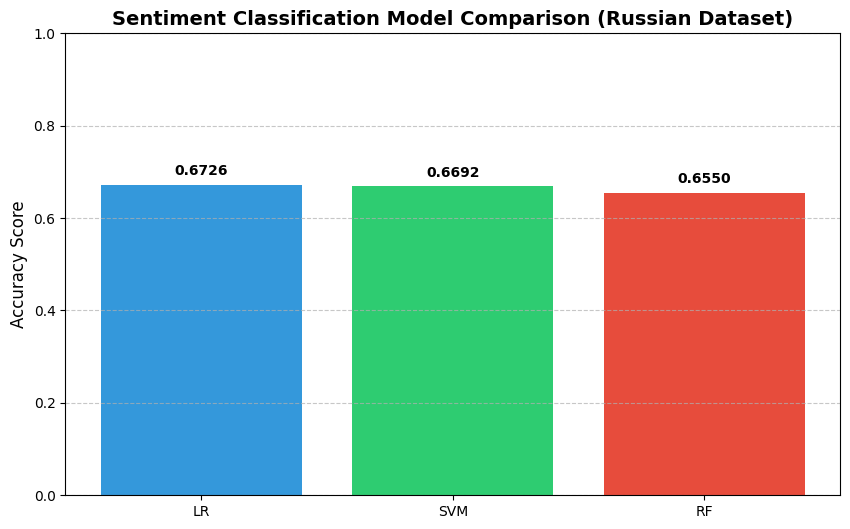

In [2]:
# Manual backup of results (if the session was restarted)
accuracy_compare = {
    'LR': [0, 0, 0, 0.6726],
    'SVM': [0, 0, 0, 0.6692],
    'RF': [0, 0, 0, 0.6550]
}

# RESULTS VISUALIZATION

import matplotlib.pyplot as plt

# 1. Prepare data for the comparison chart
# Extracting the names of the models and their corresponding Accuracy (index 3 in the results list)
model_names = list(accuracy_compare.keys())
accuracy_values = [results[3] for results in accuracy_compare.values()]

# 2. Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_values, color=['#3498db', '#2ecc71', '#e74c3c'])

# 3. Add styling and labels
plt.ylim(0, 1.0)  # Scale from 0 to 100%
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Sentiment Classification Model Comparison (Russian Dataset)', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Add numerical labels on top of each bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}", ha='center', fontweight='bold')

# 5. Save the plot as an image (optional, useful for GitHub)
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

plt.show()